In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [2]:
# Visualiza las 23 columnas
pd.set_option('display.max_columns', 23)
# Carga del CSV en un DataFrame df (usando como delimitador la coma ',')
df = pd.read_csv('train.csv')

In [3]:
columnas_iniciales = df.columns # Devuelve un índice
print(columnas_iniciales)

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')


In [4]:
# Se renombran las columnas
nombresNuevos = {
                 'id' : 'ID',
                 'titulo' : 'Titulo',
                 'descripcion' : 'Descripcion',
                 'tipodepropiedad' : 'TipoPropiedad',
                 'direccion' : 'Direccion',
                 'ciudad' : 'Ciudad',
                 'provincia' : 'Provincia',
                 'antiguedad' : 'Antiguedad',
                 'habitaciones' : 'CantHabitaciones',
                 'garages' : 'CantGarages',
                 'banos' : 'CantBanos',
                 'metroscubiertos' : 'MetrosCuadradosCubiertos',
                 'metrostotales' : 'MetrosCuadradosTotales',
                 'idzona' : 'IDZona',
                 'lat' : 'Latitud',
                 'lng' : 'Longitud',
                 'fecha' : 'Fecha',
                 'gimnasio' : 'TieneGimnasio',
                 'usosmultiples' : 'TieneUsosMultiples',
                 'piscina' : 'TienePileta',
                 'escuelascercanas' : 'TieneEscuelasCerca',
                 'centroscomercialescercanos' : 'TieneShoppingsCerca',
                 'precio' : 'Precio'
                
}

dfok = df.rename(columns = nombresNuevos)
columnas_renombradas = dfok.columns # Devuelve un índice
print(columnas_renombradas)
#columnas = dfok.columns # Devuelve un Índice
#columnas = columnas.to_series() # Convierte el Índice a Serie
# En este caso la Serie tiene un índice que coincide con los valores
#print(columnas.index)
#print('\n', columnas.values)

Index(['ID', 'Titulo', 'Descripcion', 'TipoPropiedad', 'Direccion', 'Ciudad',
       'Provincia', 'Antiguedad', 'CantHabitaciones', 'CantGarages',
       'CantBanos', 'MetrosCuadradosCubiertos', 'MetrosCuadradosTotales',
       'IDZona', 'Latitud', 'Longitud', 'Fecha', 'TieneGimnasio',
       'TieneUsosMultiples', 'TienePileta', 'TieneEscuelasCerca',
       'TieneShoppingsCerca', 'Precio'],
      dtype='object')


In [5]:
# Se Reordenan las columnas
nombresEnOrden = [
                 'ID',
                 'Titulo',
                 'TipoPropiedad',
                 'Precio',
                 'Fecha',
                 'Antiguedad',
                 'MetrosCuadradosCubiertos',
                 'MetrosCuadradosTotales',
                 'Descripcion',
                 
                 'CantHabitaciones',
                 'CantGarages',
                 'CantBanos',
               
                 'IDZona',
                 'Direccion',
                 'Ciudad',
                 'Provincia',
                 'Latitud',
                 'Longitud',
                 
                 'TieneGimnasio',
                 'TieneUsosMultiples',
                 'TienePileta',
                 'TieneEscuelasCerca',
                 'TieneShoppingsCerca'
    ]                 

dfok = dfok[nombresEnOrden]
dfok.columns

Index(['ID', 'Titulo', 'TipoPropiedad', 'Precio', 'Fecha', 'Antiguedad',
       'MetrosCuadradosCubiertos', 'MetrosCuadradosTotales', 'Descripcion',
       'CantHabitaciones', 'CantGarages', 'CantBanos', 'IDZona', 'Direccion',
       'Ciudad', 'Provincia', 'Latitud', 'Longitud', 'TieneGimnasio',
       'TieneUsosMultiples', 'TienePileta', 'TieneEscuelasCerca',
       'TieneShoppingsCerca'],
      dtype='object')

In [6]:
# Análisis de los valores booleanos (y cómo varía el precio respecto a ellos)
# print(df.columns) # Devuelve una serie con lon nombres de las columnas
columnas = ['Ciudad',
            'Provincia',
            'TieneGimnasio',
            'TieneUsosMultiples',
            'TienePileta',
            'TieneEscuelasCerca',
            'TieneShoppingsCerca',
            'Precio'] 

print(columnas)

['Ciudad', 'Provincia', 'TieneGimnasio', 'TieneUsosMultiples', 'TienePileta', 'TieneEscuelasCerca', 'TieneShoppingsCerca', 'Precio']


In [7]:
# Se indica en el Análisis exploratorio de Navent que, de las columnas usadas anterioremente,
# el precio se representa con enteros y las demás columnas son Booleanas

# Se crea un nuevo DataFrame df_abool que copia columnas de interés del DataFrame original
df_abool = dfok[columnas].copy()
memoria_usada = df_abool.memory_usage()
print('Total memoria usada sin cambios de tipos {:.2f}'.format(memoria_usada.sum()/1024/1024), 'MB')
# Se convierten lo tipos de datos a los requeridos
df_abool['TieneGimnasio'] = df_abool['TieneGimnasio'].astype(np.bool)
df_abool['TieneUsosMultiples'] = df_abool['TieneUsosMultiples'].astype(np.bool)
df_abool['TienePileta'] = df_abool['TienePileta'].astype(np.bool)
df_abool['TieneEscuelasCerca'] = df_abool['TieneEscuelasCerca'].astype(np.bool)
df_abool['TieneShoppingsCerca'] = df_abool['TieneShoppingsCerca'].astype(np.bool)

df_abool['Precio'] = df_abool['Precio'].astype(np.uint32)

df_abool['Ciudad'] = df_abool['Ciudad'].astype('category')
df_abool['Provincia'] = df_abool['Provincia'].astype('category')

print('Total memoria usada sin cambios de tipos {0:.2f}'.format(df_abool.memory_usage().sum()/1024/1024), 'MB')

Total memoria usada sin cambios de tipos 14.65 MB
Total memoria usada sin cambios de tipos 2.79 MB


# Análisis de calidad de datos pertinentes

In [8]:
# Análisis de calidad de datos
df_abool.isnull().sum()

Ciudad                 372
Provincia              155
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

Verifico si hay alguna relación entre los valores nulos de provincias y ciudades

In [9]:
df_abool[(df_abool['Ciudad'].isnull() == True) & (df_abool['Provincia'].isnull() == True)].isnull().sum()

Ciudad                 155
Provincia              155
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

Los valores de provincias nulos también tienen ciudades nulas. Como se van utilizar estos valores conviene descartarlos.

In [10]:
# Verifico qué ocurre si se eliminan los valores nulos
df_abool.dropna(subset=['Provincia'], inplace=True)
df_abool.isnull().sum()

Ciudad                 217
Provincia                0
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

In [11]:
df_abool.loc[(df_abool['Provincia'] == 'Colima') & (df_abool['Ciudad'].isnull() == True)]

,Ciudad,Provincia,TieneGimnasio,TieneUsosMultiples,TienePileta,TieneEscuelasCerca,TieneShoppingsCerca,Precio


Voy a ver cuánto influyen las cantidades de valores nulos en ciudades por provincia, para ver si es correcto eliminarlas.

In [12]:
# Creo un DataFrame donde solo se almacenen los casos con valores nulos de ciudades
cant_nulos_provincia = df_abool.loc[df_abool['Ciudad'].isnull() == True].copy() # Devuelve un DataFrame
# Elijo quedarme solo con la columna 'provincia' 
cant_nulos_provincia = cant_nulos_provincia['Provincia'] # Devuelve una Serie
# Realizo un conteo para casos nulos por provincia
cant_nulos_provincia = cant_nulos_provincia.value_counts() # Devuelve una Serie
# Paso la Serie a DataFrame
cant_nulos_provincia = cant_nulos_provincia.to_frame()
# Reseteo el índice para tener una columna con el nombre de las provincias
cant_nulos_provincia.reset_index(inplace = True)
# Le cambio el nombre a las provincias
cant_nulos_provincia = cant_nulos_provincia.rename(columns = {'index' : 'Provincia', 'Provincia' : 'cant_nulos'}).copy()
#cant_nulos_provincia
# Ordeno alfabéticamente por nombre de provincia y lo modifico "implace"
cant_nulos_provincia.sort_values(by='Provincia', ascending = True, inplace = True)
cant_nulos_provincia.reset_index(drop = True, inplace=True)

In [13]:
cant_nulos_provincia.head()

,Provincia,cant_nulos
0,Aguascalientes,0
1,Baja California Norte,0
2,Baja California Sur,0
3,Campeche,0
4,Chiapas,0


In [14]:
# Voy a crear un DataFrame para comparar la proporción de ciudades nulas por provincia
# Como adf_abool ya no tiene 'provincia' y 'ciudad' nulos a la vez, uso ese DataFrame
cant_total_provincia = df_abool['Provincia'] # Devuelve una Serie
# Convierto a DataFrame y lo asigo "inplace"
cant_total_provincia = cant_total_provincia.value_counts().to_frame()
cant_total_provincia.reset_index(inplace = True)
cant_total_provincia.rename(columns = {'index' : 'Provincia', 'Provincia' : 'cant_total'}, inplace = True)
cant_total_provincia
cant_total_provincia.sort_values(by = 'Provincia', ascending = True, inplace = True)
cant_total_provincia.reset_index(drop = True, inplace = True)

In [15]:
cant_total_provincia.head()

,Provincia,cant_total
0,Aguascalientes,1753
1,Baja California Norte,3220
2,Baja California Sur,1700
3,Campeche,263
4,Chiapas,1126


# Merge

DataFrame izquierdo ==> cant_nulos_provincia

DataFrame derecho ==> cant_total_provincia

In [16]:
df_joined = pd.merge(cant_nulos_provincia, cant_total_provincia, on='Provincia', how = 'inner')

In [17]:
df_joined = df_joined.loc[df_joined['cant_nulos'] != 0].copy()
df_joined.reset_index(drop = True, inplace = True)
# Ya se tiene un DataFrame para calcular la proporción de los valores nulos en los totales (por provincia)
df_joined

,Provincia,cant_nulos,cant_total
0,Chihuahua,46,4590
1,Distrito Federal,20,58790
2,Durango,1,2275
3,Edo. de México,18,41607
4,Guanajuato,3,2860
5,Guerrero,3,2678
6,Jalisco,21,21238
7,Morelos,2,7337
8,Nuevo León,9,15324
9,Oaxaca,3,711


## Agrego columna de proporciones

In [18]:
df_joined['propor_nulos [%]'] = df_joined['cant_nulos'] / df_joined['cant_total'] * 100
# Se redondea a dos decimales
df_joined['propor_nulos [%]'] = df_joined['propor_nulos [%]'].round(2)
df_joined

,Provincia,cant_nulos,cant_total,propor_nulos [%]
0,Chihuahua,46,4590,1.00
1,Distrito Federal,20,58790,0.03
2,Durango,1,2275,0.04
3,Edo. de México,18,41607,0.04
4,Guanajuato,3,2860,0.10
5,Guerrero,3,2678,0.11
6,Jalisco,21,21238,0.10
7,Morelos,2,7337,0.03
8,Nuevo León,9,15324,0.06
9,Oaxaca,3,711,0.42


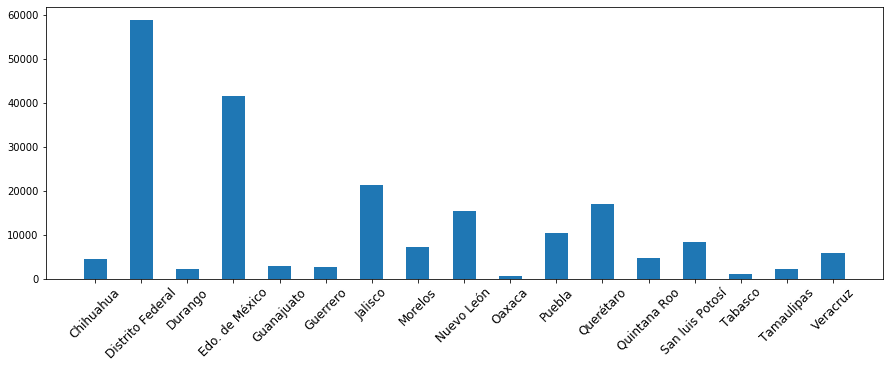

In [19]:
### Visualización de proporción de datos nulos. PUEDE NO SER NECESARIO
plt.figure(figsize = (15,5))

prov_tot = df_joined['cant_total']
prov_nul = df_joined['cant_nulos']
ancho = 0.5
ind = df_joined['Provincia']
p1 = plt.bar(ind, prov_tot, ancho)
p2 = plt.bar(ind, prov_nul, ancho)
plt.xticks(rotation = 45, fontsize = 12)

plt.show()

Se ve que no representan más del 1% de los casos totales. Enonces se pueden eliminar.

In [20]:
df_abool.isnull().sum()

Ciudad                 217
Provincia                0
TieneGimnasio            0
TieneUsosMultiples       0
TienePileta              0
TieneEscuelasCerca       0
TieneShoppingsCerca      0
Precio                   0
dtype: int64

In [21]:
df_abool.shape

(239845, 8)

In [22]:
df_abool.dropna(inplace = True)
df_abool.isnull().sum()

Ciudad                 0
Provincia              0
TieneGimnasio          0
TieneUsosMultiples     0
TienePileta            0
TieneEscuelasCerca     0
TieneShoppingsCerca    0
Precio                 0
dtype: int64

In [23]:
df_abool.shape

(239628, 8)

Media del precio de las propiedades con gimnasio $ 3812891
Media del precio de las propiedades sin gimnasio $ 2445053



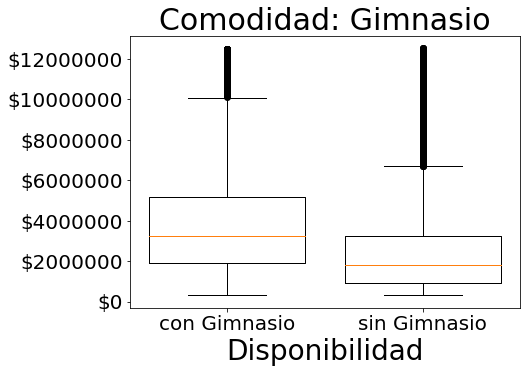

In [24]:
# Comparación directa de los servicios y disponibilidades de las propiedades

print('Media del precio de las propiedades con gimnasio $ {:.0f}'
      .format(df_abool.loc[df_abool['TieneGimnasio'] == True]['Precio'].mean()))

print('Media del precio de las propiedades sin gimnasio $ {:.0f}\n'
      .format(df_abool.loc[df_abool['TieneGimnasio'] == False]['Precio'].mean()))

fig_1 = plt.figure(1, figsize = (7,5))
sub_fig = fig_1.add_subplot(111)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
sub_fig.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.title("Comodidad: Gimnasio", fontsize = 30)
sub_fig.set_xlabel('Disponibilidad', fontsize = 28)
box_plot = sub_fig.boxplot([df_abool.loc[df_abool['TieneGimnasio'] == True]['Precio'], 
                            df_abool.loc[df_abool['TieneGimnasio'] == False]['Precio']],
                           labels = ['con Gimnasio', 'sin Gimnasio'],
                           widths = 0.8)

Media del precio de las propiedades con SUM $ 3826889
Media del precio de las propiedades sin SUM $ 2454917



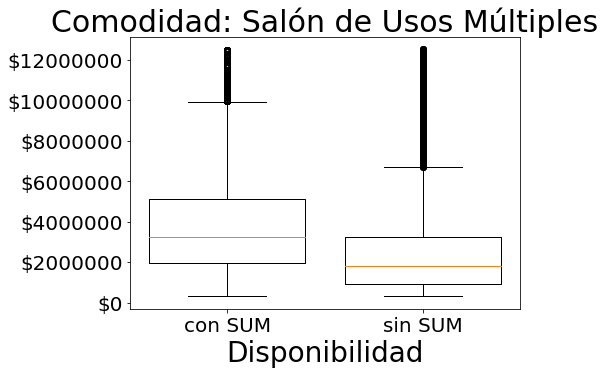

In [25]:
print('Media del precio de las propiedades con SUM $ {:.0f}'
      .format(df_abool.loc[df_abool['TieneUsosMultiples'] == True]['Precio'].mean()))

print('Media del precio de las propiedades sin SUM $ {:.0f}\n'
      .format(df_abool.loc[df_abool['TieneUsosMultiples'] == False]['Precio'].mean()))

fig_2 = plt.figure(1, figsize = (7,5))
sub_fig = fig_2.add_subplot(111)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
sub_fig.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.title("Comodidad: Salón de Usos Múltiples", fontsize = 30)
sub_fig.set_xlabel('Disponibilidad', fontsize = 28)
box_plot = sub_fig.boxplot([df_abool.loc[df_abool['TieneUsosMultiples'] == True]['Precio'], 
                            df_abool.loc[df_abool['TieneUsosMultiples'] == False]['Precio']],
                           labels = ['con SUM', 'sin SUM'],
                           widths = 0.8)

Media del precio de las propiedades con piscina $ 3315052
Media del precio de las propiedades sin piscina $ 2455453



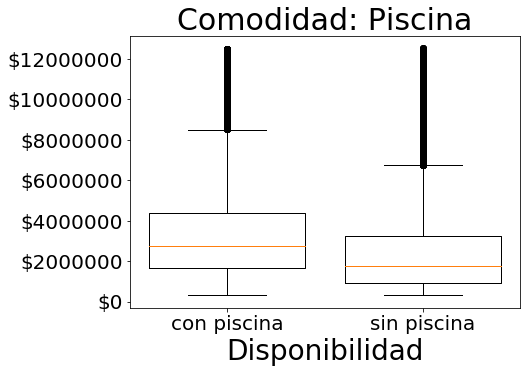

In [26]:
print('Media del precio de las propiedades con piscina $ {:.0f}'
      .format(df_abool.loc[df_abool['TienePileta'] == True]['Precio'].mean()))

print('Media del precio de las propiedades sin piscina $ {:.0f}\n'
      .format(df_abool.loc[df_abool['TienePileta'] == False]['Precio'].mean()))

fig_3 = plt.figure(1, figsize = (7,5))
sub_fig = fig_3.add_subplot(111)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
sub_fig.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.title("Comodidad: Piscina", fontsize = 30)
sub_fig.set_xlabel('Disponibilidad', fontsize = 28)
box_plot = sub_fig.boxplot([df_abool.loc[df_abool['TienePileta'] == True]['Precio'],
                            df_abool.loc[df_abool['TienePileta'] == False]['Precio']],
                           labels = ['con piscina', 'sin piscina'],
                           widths = 0.8)

Media del precio de las propiedades con escuelas cercanas $ 2533456
Media del precio de las propiedades sin escuelas cercanas $ 2528336



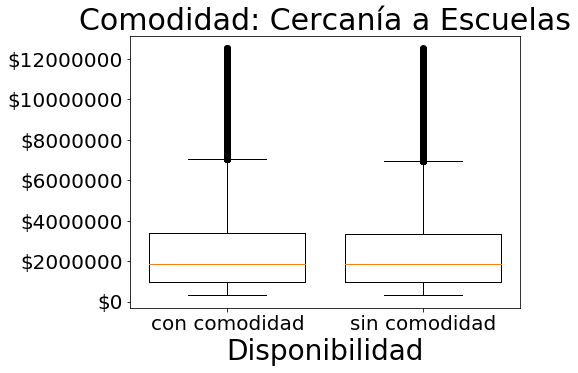

In [27]:
print('Media del precio de las propiedades con escuelas cercanas $ {:.0f}'
      .format(df_abool.loc[df_abool['TieneEscuelasCerca'] == True]['Precio'].mean()))

print('Media del precio de las propiedades sin escuelas cercanas $ {:.0f}\n'
      .format(df_abool.loc[df_abool['TieneEscuelasCerca'] == False]['Precio'].mean()))

fig_4 = plt.figure(1, figsize = (7,5))
sub_fig = fig_4.add_subplot(111)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
sub_fig.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.title("Comodidad: Cercanía a Escuelas", fontsize = 30)
sub_fig.set_xlabel('Disponibilidad', fontsize = 28)
box_plot = sub_fig.boxplot([df_abool.loc[df_abool['TieneEscuelasCerca'] == True]['Precio'],
                            df_abool.loc[df_abool['TieneEscuelasCerca'] == False]['Precio']],
                           labels = ['con comodidad', 'sin comodidad'],
                           widths = 0.8)

Media del precio de las propiedades con centros comerciales cencanos $ 2605484
Media del precio de las propiedades sin centros comerciales cencanos $ 2481294



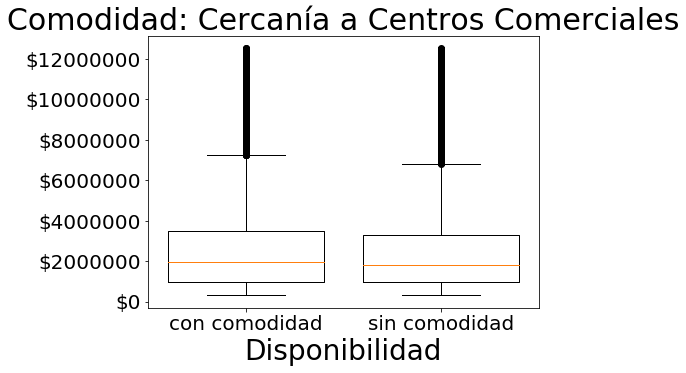

In [28]:
print('Media del precio de las propiedades con centros comerciales cencanos $ {:.0f}'
      .format(df_abool.loc[df_abool['TieneShoppingsCerca'] == True]['Precio'].mean()))

print('Media del precio de las propiedades sin centros comerciales cencanos $ {:.0f}\n'
      .format(df_abool.loc[df_abool['TieneShoppingsCerca'] == False]['Precio'].mean()))

fig_5 = plt.figure(1, figsize = (7,5))
sub_fig = fig_5.add_subplot(111)
plt.xticks(rotation = 0, fontsize = 20)
plt.yticks(fontsize = 20)
# Para formatear los ejes
sub_fig.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.title("Comodidad: Cercanía a Centros Comerciales", fontsize = 30)
sub_fig.set_xlabel('Disponibilidad', fontsize = 28)
box_plot = sub_fig.boxplot([df_abool.loc[df_abool['TieneShoppingsCerca'] == True]['Precio'],
                            df_abool.loc[df_abool['TieneShoppingsCerca'] == False]['Precio']],
                           labels = ['con comodidad', 'sin comodidad'],
                           widths = 0.8)

In [29]:
solo_gimnasio = df_abool.loc[(df_abool['TieneGimnasio'] == True) & 
                             (df_abool['TieneUsosMultiples'] == False) & 
                             (df_abool['TienePileta'] == False)]

solo_sum = df_abool.loc[(df_abool['TieneGimnasio'] == False) & 
                        (df_abool['TieneUsosMultiples'] == True) & 
                        (df_abool['TienePileta'] == False)]

solo_piscina = df_abool.loc[(df_abool['TieneGimnasio'] == False) & 
                            (df_abool['TieneUsosMultiples'] == False) & 
                            (df_abool['TienePileta'] == True)]

In [30]:
# Solo con SUM

print('Media del precio de las propiedades con solo Gimnasio $ {:.0f}'
      .format(solo_gimnasio['Precio'].mean()))

print('Media del precio de las propiedades con solo SUM $ {:.0f}'
      .format(solo_sum['Precio'].mean()))

print('Media del precio de las propiedades con solo Piscina $ {:.0f}'
      .format(solo_piscina['Precio'].mean()))

Media del precio de las propiedades con solo Gimnasio $ 3056434
Media del precio de las propiedades con solo SUM $ 3593696
Media del precio de las propiedades con solo Piscina $ 2719016


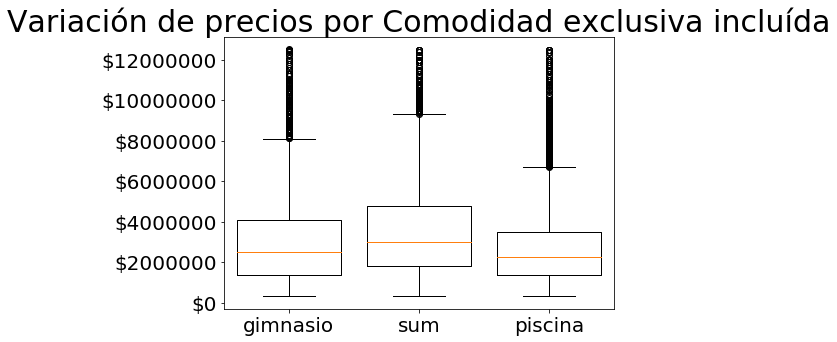

In [31]:
# Análisis por exclusión de las distintas comodidades
fig_6 = plt.figure(6, figsize = (7,5))
sub_fig = fig_6.add_subplot(111)
plt.xticks(rotation = 0, fontsize = 20)
plt.yticks(fontsize = 20)
# Para formatear los ejes
sub_fig.yaxis.set_major_formatter(FormatStrFormatter('$%.0f'))
plt.title("Variación de precios por Comodidad exclusiva incluída", fontsize = 30)
box_plot = sub_fig.boxplot([solo_gimnasio['Precio'], solo_sum['Precio'], solo_piscina['Precio']],
                           labels = ['gimnasio', 'sum','piscina'],
                           widths = 0.8)

In [32]:
df_abool.shape

(239628, 8)

In [33]:
solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Edo. de México']

,Ciudad,Provincia,TieneGimnasio,TieneUsosMultiples,TienePileta,TieneEscuelasCerca,TieneShoppingsCerca,Precio
182,Tlalnepantla de Baz,Edo. de México,True,False,False,True,True,2700000
282,Toluca,Edo. de México,True,False,False,True,True,560000
359,Naucalpan de Juárez,Edo. de México,True,False,False,False,False,4450000
521,Lerma,Edo. de México,True,False,False,True,True,650000
822,Atizapán de Zaragoza,Edo. de México,True,False,False,False,False,2190000
929,Atizapán de Zaragoza,Edo. de México,True,False,False,False,False,6990000
2152,Huehuetoca,Edo. de México,True,False,False,True,True,405000
2161,Ecatepec de Morelos,Edo. de México,True,False,False,True,True,1100000
2298,Huixquilucan,Edo. de México,True,False,False,True,True,2050000
3035,Huixquilucan,Edo. de México,True,False,False,True,True,4500000


In [34]:
provincias_nombres = dfok['Provincia'].unique()
provincias_nombres

array(['Distrito Federal', 'Jalisco', 'Edo. de México', 'Oaxaca',
       'Quintana Roo', 'Colima', 'San luis Potosí', 'Nuevo León',
       'Querétaro', 'Tamaulipas', 'Puebla', 'Yucatán', 'Morelos',
       'Guerrero', 'Tabasco', 'Guanajuato', 'Hidalgo', 'Veracruz',
       'Chihuahua', 'Aguascalientes', 'Sonora', 'Michoacán',
       'Baja California Norte', 'Baja California Sur', 'Coahuila',
       'Durango', 'Sinaloa', 'Chiapas', 'Nayarit', 'Tlaxcala', 'Campeche',
       'Zacatecas', nan], dtype=object)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 <a list of 32 Text xticklabel objects>)

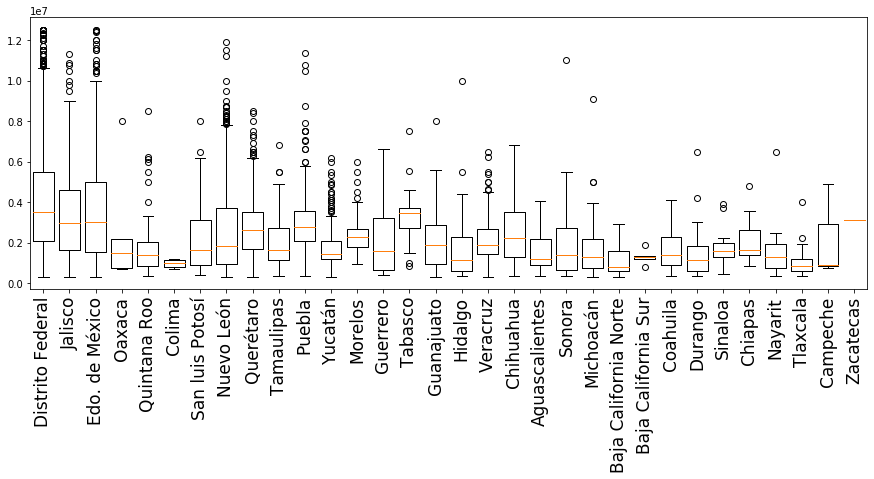

In [36]:
fig_7 = plt.figure(7, figsize = (15,5))
sub_fig = fig_7.add_subplot(111)
box_plot = sub_fig.boxplot([solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Distrito Federal']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Jalisco']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Edo. de México']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Oaxaca']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Quintana Roo']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Colima']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'San luis Potosí']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Nuevo León']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Querétaro']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Tamaulipas']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Puebla']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Yucatán']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Morelos']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Guerrero']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Tabasco']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Guanajuato']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Hidalgo']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Veracruz']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Chihuahua']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Aguascalientes']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Sonora']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Michoacán']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Baja California Norte']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Baja California Sur']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Coahuila']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Durango']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Sinaloa']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Chiapas']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Nayarit']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Tlaxcala']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Campeche']['Precio'], \
                            solo_gimnasio.loc[solo_gimnasio['Provincia'] == 'Zacatecas']['Precio']], \
                           labels = ['Distrito Federal', \
                                     'Jalisco', \
                                     'Edo. de México', \
                                     'Oaxaca', \
                                     'Quintana Roo', \
                                     'Colima', \
                                     'San luis Potosí', \
                                     'Nuevo León', \
                                     'Querétaro', \
                                     'Tamaulipas', \
                                     'Puebla', \
                                     'Yucatán', \
                                     'Morelos', \
                                     'Guerrero', \
                                     'Tabasco', \
                                     'Guanajuato', \
                                     'Hidalgo', \
                                     'Veracruz', \
                                     'Chihuahua', \
                                     'Aguascalientes', \
                                     'Sonora', \
                                     'Michoacán', \
                                     'Baja California Norte', \
                                     'Baja California Sur', \
                                     'Coahuila', \
                                     'Durango', \
                                     'Sinaloa', \
                                     'Chiapas', \
                                     'Nayarit', \
                                     'Tlaxcala', \
                                     'Campeche', \
                                     'Zacatecas'], \
                           widths = 0.8)
plt.xticks(rotation = 90, fontsize = 17)